In [0]:
import glob
import os
from PIL import Image
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Homework 2, part 1

## transfer learning
1. below you will find the dataset object for the galaxy dataset from homework 1, except that now it outputs a 69x69 image (no flattening), and the single grayscale channel is repeated 3 times to give a 3x69x69 image

2. load a pre-trained network from pytorchs selection https://pytorch.org/docs/stable/torchvision/models.html

3. create a network to classify the galaxy image dataset with some parts from the pretrained network

4. train the new network

5. when you reach over 75% accuracy on the validation dataset, submit your trained model (state_dict and source code)

6. double check that if you train the same model without the pre-trained weights, it will perform worse (no need to submit this model) 

In [0]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu' )

In [0]:
import zipfile
import io
dir_path = 'drive/My Drive/Colab Notebooks/HW2'

zip_ref = zipfile.ZipFile(os.path.join(dir_path, 'Dataset.zip'), 'r')
zip_ref.extractall()

path_to_training_data = 'Dataset/train/'
path_to_validation_data = 'Dataset/validation/'

In [0]:
import glob
from PIL import Image
from PIL import ImageFilter
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


class CustomDataset(Dataset):
    def __init__(self, path,mean=0.092,std=0.127,n_classes=10,transform=False):
        
        self.mean = mean
        self.std = std
        
        self.do_transform = transform
        self.transform = transforms.RandomRotation(180)
        
        self.filelist = glob.glob(path+'/*.png')
        
        self.labels = np.zeros(len(self.filelist))
        
        for class_i in range(n_classes):
            self.labels[ np.array(['class'+str(class_i) in x for x in self.filelist]) ] = class_i
        self.labels = torch.LongTensor(self.labels)
      
        self.imgs = []
        for fname in self.filelist:
            img = Image.open(fname)
            self.imgs.append(img)
  
    def __len__(self):
       
        return len(self.filelist)

    def __getitem__(self, idx):
        
        img = self.imgs[idx]
    
        if self.do_transform:
            
            img = self.transform(img)
        
        
        x = transforms.ToTensor()(img)
        
        x = (x-self.mean)/self.std
        
        x = x.repeat(3,1,1)
        
        
        class_label = self.labels[idx]
        
        return x, class_label

In [0]:
train_ds = CustomDataset(path_to_training_data,transform=False)
valid_ds = CustomDataset(path_to_validation_data,transform=False)

In [0]:
x,y = train_ds[553]

In [8]:
x.shape

torch.Size([3, 69, 69])

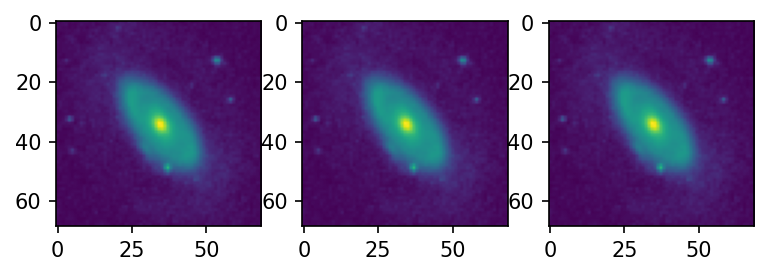

In [9]:
fig,ax = plt.subplots(1,3,figsize=(6,2),dpi=150)

for i in range(3):
    ax[i].imshow(x[i])

In [0]:
class ImageClassifier(nn.Module):

    def __init__(self, model):
        super(ImageClassifier, self).__init__()
        
        self.model = model
        
    def forward(self, x):
        out = self.model(x)
        
        return out

In [13]:
resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)
resnet18 = resnet18.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
model = ImageClassifier(resnet18)

In [0]:
import torch.optim as optim #, lr_scheduler

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 


In [0]:
save_path = 'drive/My Drive/Colab Notebooks/HW2'

In [0]:
import time
import copy 

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), os.path.join(save_path, 'transfer_best_model_resnet_yahel.pt'))

        print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
image_datasets = {'train': train_ds, 'val': valid_ds}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {'train': len(train_ds), 'val': len(valid_ds)}


In [21]:
model_ft = train_model(model, loss_func, optimizer, None,
                       num_epochs=40)

Epoch 0/39
----------
train Loss: 0.4387 Acc: 0.8409
val Loss: 0.7103 Acc: 0.7556

Training complete in 0m 54s
Epoch 1/39
----------
train Loss: 0.4040 Acc: 0.8584
val Loss: 0.7442 Acc: 0.7634

Training complete in 1m 47s
Epoch 2/39
----------
train Loss: 0.3607 Acc: 0.8698
val Loss: 0.7755 Acc: 0.7518

Training complete in 2m 41s
Epoch 3/39
----------
train Loss: 0.3255 Acc: 0.8838
val Loss: 0.8087 Acc: 0.7458

Training complete in 3m 34s
Epoch 4/39
----------
train Loss: 0.3092 Acc: 0.8940
val Loss: 0.7917 Acc: 0.7540

Training complete in 4m 28s
Epoch 5/39
----------
train Loss: 0.2583 Acc: 0.9090
val Loss: 0.8727 Acc: 0.7308

Training complete in 5m 21s
Epoch 6/39
----------
train Loss: 0.2371 Acc: 0.9162
val Loss: 0.8092 Acc: 0.7724

Training complete in 6m 15s
Epoch 7/39
----------
train Loss: 0.2013 Acc: 0.9272
val Loss: 0.9955 Acc: 0.7138

Training complete in 7m 9s
Epoch 8/39
----------
train Loss: 0.1770 Acc: 0.9383
val Loss: 0.8981 Acc: 0.7494

Training complete in 8m 3s
Epo

In [0]:
model = ImageClassifier(resnet18)

loaded_state_dict = torch.load(os.path.join(save_path, 'transfer_best_model_resnet_yahel.pt'))
# loaded_state_dict
model.load_state_dict(loaded_state_dict)
loaded_model = model

In [20]:
running_loss, running_corrects = 0, 0
phase = 'val'

for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # zero the parameter gradients
    loaded_model.eval()

    outputs = loaded_model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = loss_func(outputs, labels)

                # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

valid_loss = running_loss / dataset_sizes[phase]
valid_acc = running_corrects.double() / dataset_sizes[phase]

print(valid_acc)

tensor(0.7724, device='cuda:0', dtype=torch.float64)
